In [ ]:
import os
import zipfile

local_zip = '/content/Fake_news.zip'

zip_ref = zipfile.ZipFile(local_zip, 'r')

zip_ref.extractall('/content')
zip_ref.close()

In [ ]:
import nltk
nltk.download('punkt')
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud,STOPWORDS
import re
from nltk.stem import PorterStemmer,WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize,sent_tokenize
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from tensorflow.keras.preprocessing.text import one_hot,Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Flatten,Embedding,Input,LSTM,Conv1D,MaxPool1D,Bidirectional
from tensorflow.keras.models import Model
#from jupyterthemes import jtplot
#jtplot.style(theme='monokai',context='notebook',ticks=True,grid=False)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
df_true=pd.read_csv('/content/Fake_news/True.csv')
df_fake=pd.read_csv('/content/Fake_news/Fake.csv')

In [ ]:
df_true['isfake']=1
df_fake['isfake']=0
df=pd.concat([df_true,df_fake]).reset_index(drop=True)
df

,title,text,subject,date,isfake
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017",1
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017",1
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017",1
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017",1
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017",1
...,...,...,...,...,...
44893,McPain: John McCain Furious That Iran Treated ...,21st Century Wire says As 21WIRE reported earl...,Middle-east,"January 16, 2016",0
44894,JUSTICE? Yahoo Settles E-mail Privacy Class-ac...,21st Century Wire says It s a familiar theme. ...,Middle-east,"January 16, 2016",0
44895,Sunnistan: US and Allied ‘Safe Zone’ Plan to T...,Patrick Henningsen 21st Century WireRemember ...,Middle-east,"January 15, 2016",0
44896,How to Blow $700 Million: Al Jazeera America F...,21st Century Wire says Al Jazeera America will...,Middle-east,"January 14, 2016",0


In [ ]:
df.drop(columns=['date'],inplace=True)
df['original']=df['title']+' '+df['text']
df.head()

,title,text,subject,isfake,original
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,1,"As U.S. budget fight looms, Republicans flip t..."
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,1,U.S. military to accept transgender recruits o...
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,1,Senior U.S. Republican senator: 'Let Mr. Muell...
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,1,FBI Russia probe helped by Australian diplomat...
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,1,Trump wants Postal Service to charge 'much mor...


In [ ]:
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words=stopwords.words('english')
stop_words.extend(['from','subject','re','edu','use'])

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
def preprocess(text):
  result=[]
  for token in gensim.utils.simple_preprocess(text):
    if token not in gensim.parsing.preprocessing.STOPWORDS and len(token)>3 and token not in stop_words:
      result.append(token)
  return result

In [ ]:
df['clean']=df['original'].apply(preprocess)

In [ ]:
list_of_words=[]
for i in df.clean:
  for j in i:
    list_of_words.append(j)

In [ ]:
total_words=len(list(set(list_of_words)))
print(total_words)

108705


In [ ]:
df['clean_joined']=df['clean'].apply(lambda x:' '.join(x))

In [ ]:
df.head()

,title,text,subject,isfake,original,clean,clean_joined
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,1,"As U.S. budget fight looms, Republicans flip t...","[budget, fight, looms, republicans, flip, fisc...",budget fight looms republicans flip fiscal scr...
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,1,U.S. military to accept transgender recruits o...,"[military, accept, transgender, recruits, mond...",military accept transgender recruits monday pe...
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,1,Senior U.S. Republican senator: 'Let Mr. Muell...,"[senior, republican, senator, mueller, washing...",senior republican senator mueller washington r...
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,1,FBI Russia probe helped by Australian diplomat...,"[russia, probe, helped, australian, diplomat, ...",russia probe helped australian diplomat washin...
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,1,Trump wants Postal Service to charge 'much mor...,"[trump, wants, postal, service, charge, amazon...",trump wants postal service charge amazon shipm...


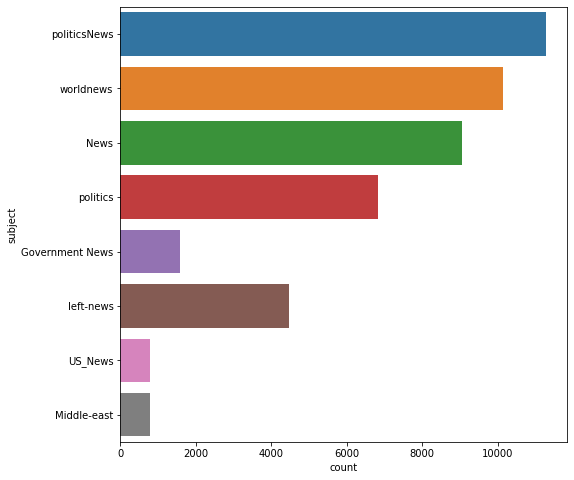

In [ ]:
plt.figure(figsize=(8,8))
sns.countplot(y='subject',data=df)

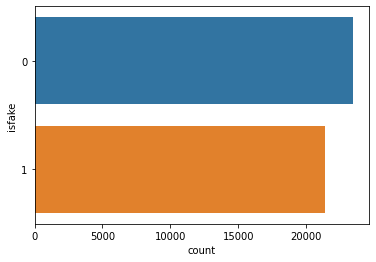

In [ ]:
sns.countplot(y='isfake',data=df)

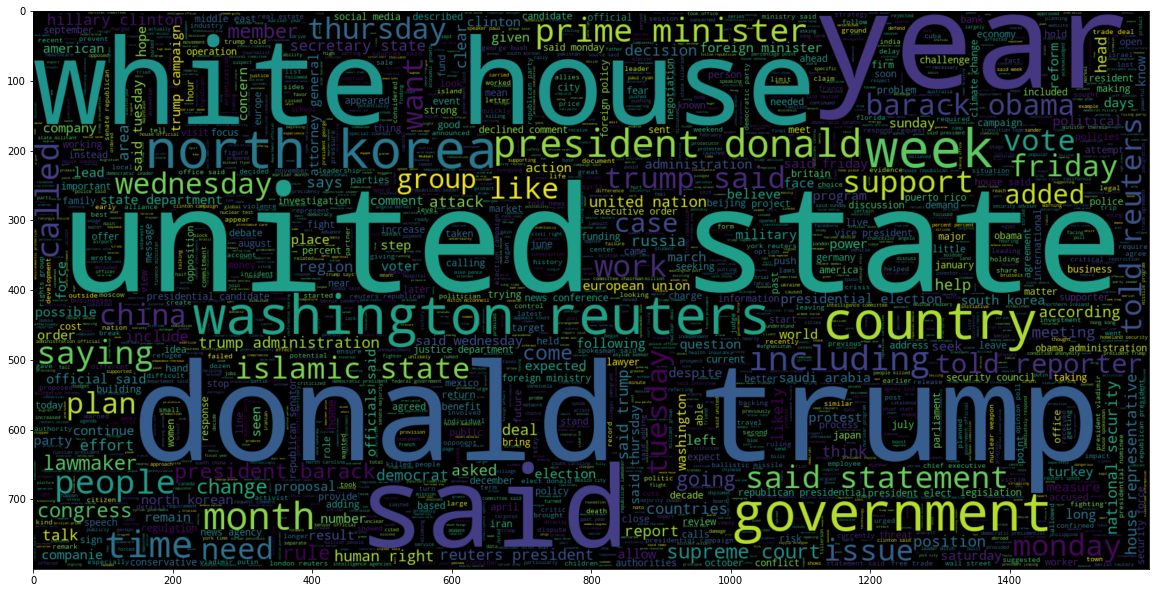

In [ ]:
plt.figure(figsize=(20,20))
wc=WordCloud(max_words=2000,width=1600,height=800,stopwords=stop_words).generate(' '.join(df[df.isfake==1].clean_joined))
plt.imshow(wc,interpolation='bilinear')

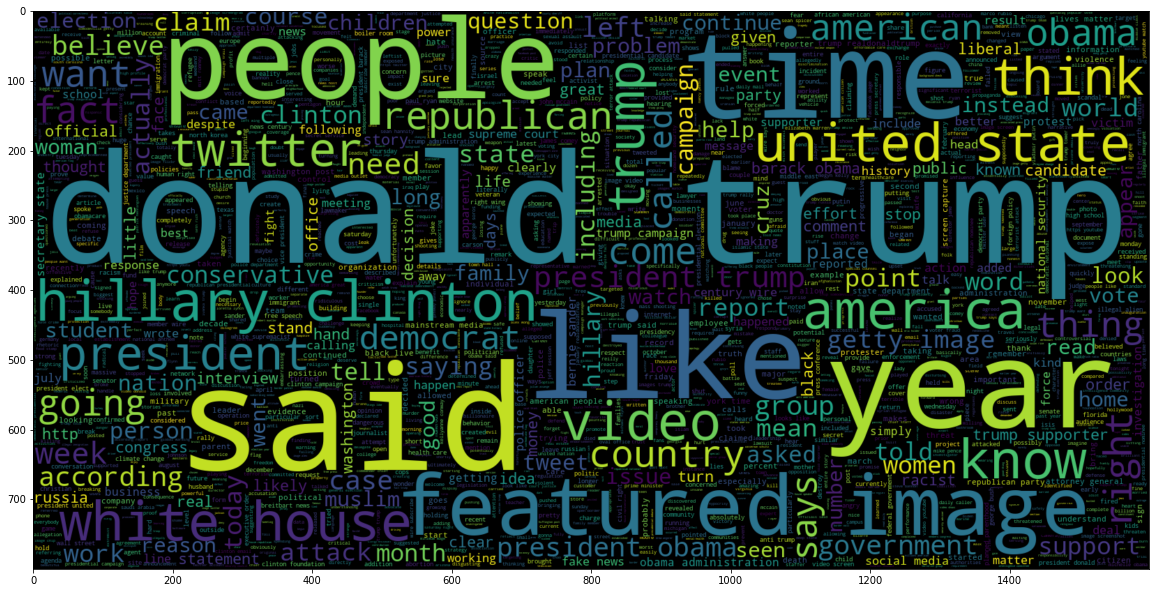

In [ ]:
plt.figure(figsize=(20,20))
wc=WordCloud(max_words=2000,width=1600,height=800,stopwords=stop_words).generate(' '.join(df[df.isfake==0].clean_joined))
plt.imshow(wc,interpolation='bilinear')

In [ ]:
maxlen=-1
for doc in df.clean_joined:
  tokens=nltk.word_tokenize(doc)
  if(maxlen<len(tokens)):
    maxlen=len(tokens)

NameError: ignored

In [ ]:
import plotly.express as px
fig=px.histogram(x=[len(nltk.word_tokenize(x)) for x in df.clean_joined],nbins=100)
fig.show()

In [ ]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(df.clean_joined, df.isfake, test_size = 0.2)

In [ ]:
from nltk import word_tokenize
tokenizer=Tokenizer(num_words=total_words)
tokenizer.fit_on_texts(x_train)
train_sequences=tokenizer.texts_to_sequences(x_train)
test_sequences=tokenizer.texts_to_sequences(x_test)

In [ ]:
padded_train=pad_sequences(train_sequences,maxlen=maxlen,padding='post',truncating='post')
padded_test=pad_sequences(test_sequences,maxlen=maxlen,truncating='post')

In [ ]:
for i,doc in enumerate(padded_train[:2]):
  print('The padded encoding for document',i+1,' is :',doc)

The padded encoding for document 1  is : [ 858 6673 4157 ...    0    0    0]
The padded encoding for document 2  is : [97 27 97 ...  0  0  0]


In [ ]:
from tensorflow.keras.layers import Dropout
model=Sequential()
model.add(Embedding(total_words,output_dim=240))
#model.add(Bidirectional(LSTM(128,return_sequences=True)))
model.add(Bidirectional(LSTM(128)))
model.add(Dense(128,activation='relu'))
#model.add(Dropout(.25))
model.add(Dense(1,activation='sigmoid'))
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['acc'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 240)         26089200  
_________________________________________________________________
bidirectional (Bidirectional (None, 256)               377856    
_________________________________________________________________
dense (Dense)                (None, 128)               32896     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 26,500,081
Trainable params: 26,500,081
Non-trainable params: 0
_________________________________________________________________


In [ ]:
y_train=np.asarray(y_train)

In [ ]:
model.fit(padded_train,y_train,batch_size=1,validation_split=.1,epochs=2)

Epoch 1/2
32326/32326 [==============================] - 31450s 973ms/step - loss: 0.0229 - acc: 0.9940 - val_loss: 0.0132 - val_acc: 0.9981
Epoch 2/2
 3197/32326 [=>............................] - ETA: 7:35:31 - loss: 0.0099 - acc: 0.9991